In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import requests
import urllib
import cv2
import re
from io import BytesIO
from PIL import Image
import requests, os
from os import path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

In [2]:
# Load data set
data=pd.read_csv("/content/db.csv")

data=data.reset_index()
data=data.rename(columns={"index":"PID"})
data.head(5)

,PID,Product_name,Product_Brand,Product_Image,Product_Price,Product_Reviews,Product_Rating,output
0,0,Replay Full Sleeves White Shirt with Regular C...,KINGDOM OF WHITE,https://m.media-amazon.com/images/I/61qKBlv1H6...,1199.0,NaN,NaN,shirt
1,1,Wave Full Sleeves White Formal Shirt with Regu...,KINGDOM OF WHITE,https://m.media-amazon.com/images/I/41lBhxltL+...,1599.0,NaN,NaN,shirt
2,2,Men's Cotton Full Sleeve Slim Fit Casual Solid...,Urbano Fashion,https://m.media-amazon.com/images/I/61NuvgzMdS...,749.0,NaN,NaN,shirt
3,3,White Solid Cotton Full Sleeves Casual Shirt f...,SHIRT THEORY,https://m.media-amazon.com/images/I/515SAzqW7t...,839.0,14.0,3.7,shirt
4,4,Men's Solid Slim Fit Cotton Casual Shirt with ...,Dennis Lingo,https://m.media-amazon.com/images/I/61XzMtVz3P...,569.0,29994.0,3.8,shirt


In [3]:
# Checking the unique observations, datatype & null values for every feature
d = {"Feature":[i for i in data.columns], "Number of unique values":data.nunique().values, 'Data Type':data.dtypes.values, "Number of null values" : data.isnull().sum() }
description = pd.DataFrame(data = d)
description

,Feature,Number of unique values,Data Type,Number of null values
PID,PID,1777,int64,0
Product_name,Product_name,1163,object,0
Product_Brand,Product_Brand,368,object,0
Product_Image,Product_Image,1730,object,0
Product_Price,Product_Price,556,float64,39
Product_Reviews,Product_Reviews,610,float64,252
Product_Rating,Product_Rating,32,float64,252
output,output,5,object,0


In [4]:
# Replacing null values with a predefined value (0)
data['Product_Brand'].fillna(value = "Not Given" , inplace = True)
data['Product_Reviews'].fillna(value = 0 , inplace = True)
data['Product_Rating'].fillna(value = 0 , inplace = True)
data['Product_Price'].fillna(value = 0 , inplace = True)

# Changing the data type from int to float
data["Product_Price"]=data["Product_Price"].astype(float)

In [5]:
# Decsription of dataset
data.describe()

,PID,Product_Price,Product_Reviews,Product_Rating
count,1777.000000,1777.000000,1777.000000,1777.000000
mean,888.000000,1734.487338,1836.259426,3.339111
std,513.120031,6514.101360,7365.876919,1.459416
min,0.000000,0.000000,0.000000,0.000000
25%,444.000000,399.000000,3.000000,3.400000
50%,888.000000,781.000000,73.000000,3.800000
75%,1332.000000,1299.000000,813.000000,4.100000
max,1776.000000,103392.000000,143973.000000,5.000000


<Axes: xlabel='Product_Rating', ylabel='Density'>

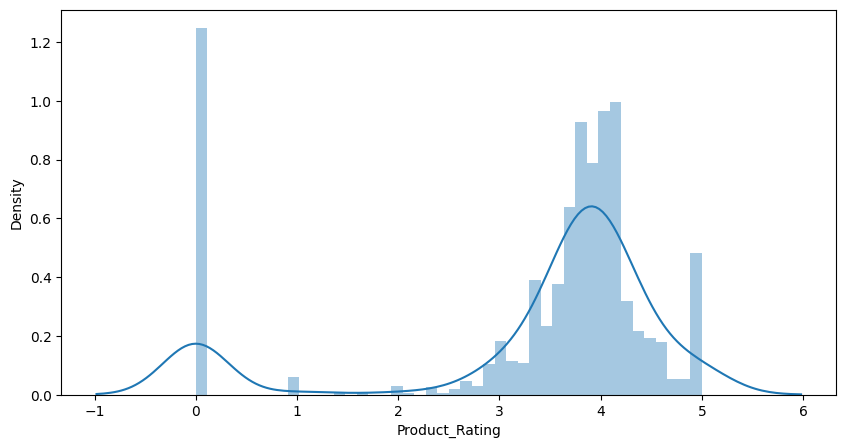

In [6]:
# Rating distribution of product dataset
plt.figure(figsize=(10,5))
sns.distplot(data["Product_Rating"])

(0.0, 15000.0)

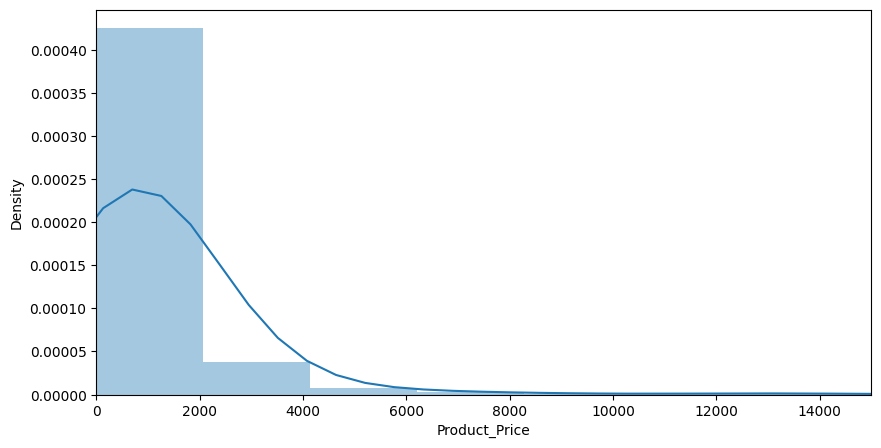

In [7]:
# Price distribution of product dataset
plt.figure(figsize=(10,5))
ax=sns.distplot(data["Product_Price"])
ax.set_xlim(0, 15000)

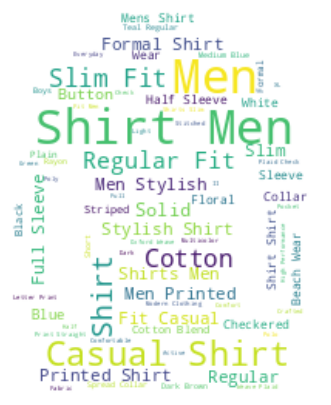

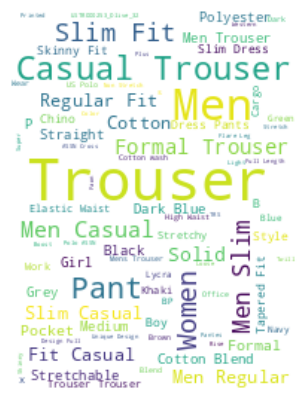

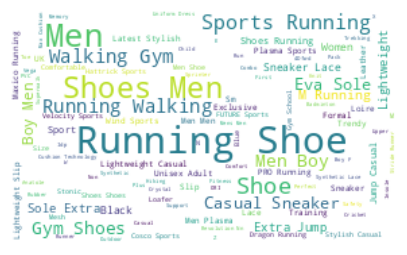

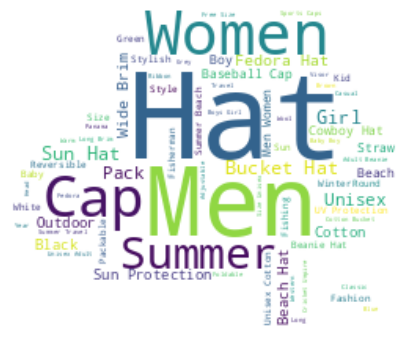

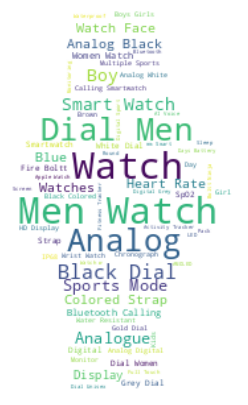

In [8]:
# Wordclouds

# Accepts apparel class and returns product name joined with a space
def product_join(name):
    return " ".join(t for t in data[data["output"]==name].Product_name)

# Load mask images
shirt_mask = np.array(Image.open(path.join("/content/shirts.jpg")))
trousers_mask = np.array(Image.open(path.join("/content/trousers.jpg")))
shoe_mask = np.array(Image.open(path.join("/content/shoe.jpg")))
hat_mask = np.array(Image.open(path.join("/content/hat.jpg")))
watch_mask = np.array(Image.open(path.join("/content/watch.jpg")))
list_masks = [shirt_mask, trousers_mask, shoe_mask, hat_mask, watch_mask]
list_name=["shirt", "trousers", "shoe", "hat", "watch"]

for i in range(len(list_masks)):
    wordcloud = WordCloud(background_color="white",  mask=list_masks[i]).generate(product_join(list_name[i]))
    plt.figure(figsize=[5,5])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [9]:
# Class Distribution
pd.DataFrame(data['output'].value_counts())

,output
shoe,385
shirt,359
hat,354
trousers,340
watch,339


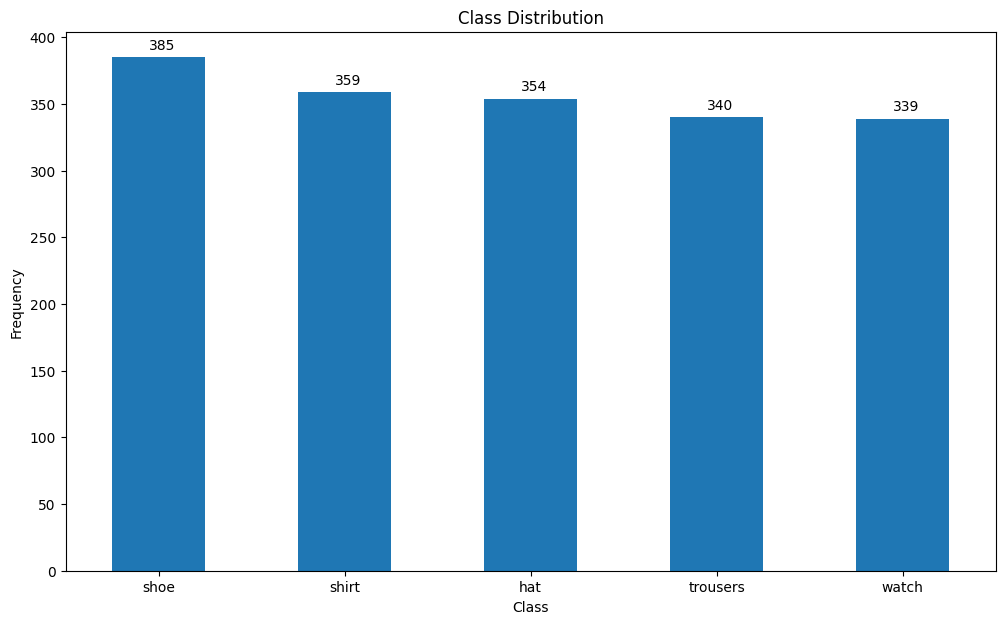

In [10]:
# Plotting class distribution
plt.figure(figsize=(12,7))
count_classes = pd.value_counts(data['output'], sort = True)
ax=count_classes.plot(kind = 'bar', rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
for p in ax.patches:
      ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+6))
plt.show()

<Response [200]>
shirt
<Response [200]>
trousers
<Response [200]>
shoe
<Response [200]>
hat
<Response [200]>
watch


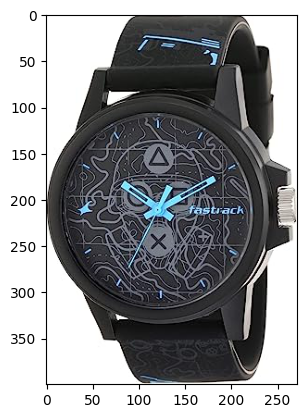

In [12]:
# Accepts image url and returns picture
def display_img(url):
    response = requests.get(url)
    print(response)
    img = Image.open(BytesIO(response.content))
    return plt.imshow(img)

for i in (300, 600, 936, 1200, 1500):
    display_img(data['Product_Image'][i])
    print(data['output'][i])

# **Image Classification** <a class="anchor" id="1"></a>

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.random import set_seed
from tensorflow.keras import regularizers
from keras.layers.core import Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [20]:
# Accepts image url and converts image to array after resizing to uniform size
def img_array(i):
    img = data['Product_Image'][i]
    try:
        response = urllib.request.urlopen(img)
    except:
        return (img_array(i - 1))
    image = np.asarray(bytearray(response.read()), dtype="uint8")
    image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image_bgr = cv2.resize(image_bgr, (224,224))
    return image_bgr

# Storing all images in dataset into arrays
image_array=[]
for i in range(len(data['Product_Image'])):
    print (i, end=" ")
    image_array.append(img_array(i))

img_arr=np.array(image_array)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [21]:
# Encoding categorical string class labels into categorical numeric
data['output'][data['output']=='shirt']=0
data['output'][data['output']=='trousers']=1
data['output'][data['output']=='shoe']=2
data['output'][data['output']=='hat']=3
data['output'][data['output']=='watch']=4
data['output']=data['output'].astype(int)

# Train-Test Split
train_images, test_images, train_labels, test_labels=train_test_split(img_arr, data['output'], test_size=0.30, random_state=42, shuffle=True)

# Normalize pixel values of image (between 0 and 1)
train_images, test_images = train_images / 255.0, test_images / 255.0

In [22]:
# CNN for Image Classification
set_seed(42)
cnn = Sequential()

# Convolutional layers
cnn.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', input_shape=train_images[0].shape, kernel_regularizer=regularizers.l1(1e-5)))
cnn.add(layers.MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(.20))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(Dropout(.20))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(Dropout(.20))

# Fully-connected layers
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(Dropout(.20))
cnn.add(layers.Dense(5, activation='softmax'))

In [23]:
# Compile the model
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Fit the model
model = cnn.fit(train_images, train_labels, epochs=10, validation_split=0.2, callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3))

Epoch 1/10
32/32 [==============================] - 112s 3s/step - loss: 1.6782 - accuracy: 0.3642 - val_loss: 1.4068 - val_accuracy: 0.3855
Epoch 2/10
32/32 [==============================] - 109s 3s/step - loss: 1.0749 - accuracy: 0.5926 - val_loss: 1.0138 - val_accuracy: 0.6787
Epoch 3/10
32/32 [==============================] - 111s 3s/step - loss: 0.8336 - accuracy: 0.6781 - val_loss: 0.6291 - val_accuracy: 0.7831
Epoch 4/10
32/32 [==============================] - 110s 3s/step - loss: 0.5662 - accuracy: 0.7867 - val_loss: 0.4619 - val_accuracy: 0.8594
Epoch 5/10
32/32 [==============================] - 107s 3s/step - loss: 0.5439 - accuracy: 0.7918 - val_loss: 0.4357 - val_accuracy: 0.8273
Epoch 6/10
32/32 [==============================] - 111s 3s/step - loss: 0.3559 - accuracy: 0.8400 - val_loss: 0.3788 - val_accuracy: 0.8795
Epoch 7/10
32/32 [==============================] - 110s 3s/step - loss: 0.2966 - accuracy: 0.8793 - val_loss: 0.3380 - val_accuracy: 0.8876
Epoch 8/10
32

In [24]:
cnn.save('/model_cnn.h5')

In [25]:
# Prediction on the test image
cnn_pred = cnn.predict(test_images, verbose=1)
cnn_pred = np.argmax(cnn_pred, axis=1)

17/17 [==============================] - 14s 805ms/step


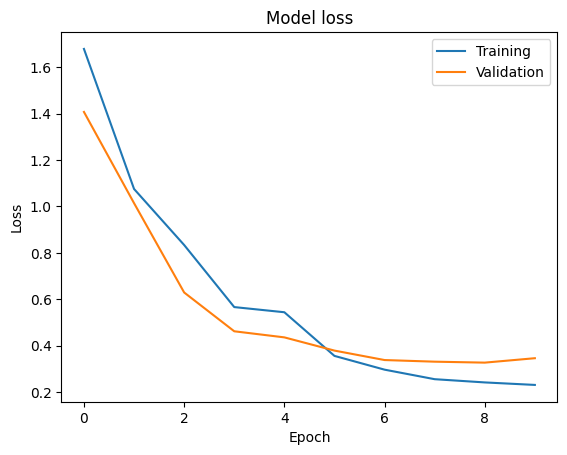

In [26]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [27]:
print("Accuracy : ", cnn.evaluate(test_images, test_labels))

17/17 [==============================] - 14s 809ms/step - loss: 0.3669 - accuracy: 0.8652
Accuracy :  [0.36692187190055847, 0.8651685118675232]


<Axes: >

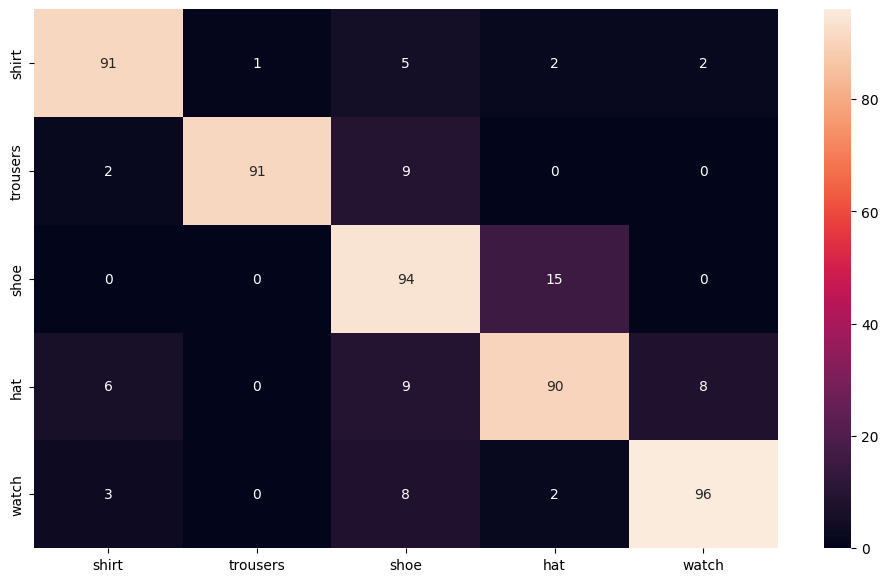

In [28]:
classes = ('shirt', 'trousers', 'shoe', 'hat', 'watch')
cf_matrix = confusion_matrix(test_labels, cnn_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt='g')
#plt.savefig(conf_matrix_map)

In [29]:
test_labels=test_labels.tolist() # converting the test_labels into a list

# Creating a function which picks random images and identifies the class to which the image belongs
def get_image_and_class(size):
  idx = np.random.randint(len(test_images), size=size) # generating a random image from the test data
  for i in range(len(idx)):
    plt.imshow(test_images[idx,:][i])
    plt.show()

  # Print the class of the random image picked above
    if test_labels[idx[i]] == 0:
      print('Shirt')
    elif test_labels[idx[i]] == 1:
      print('Trousers')
    elif test_labels[idx[i]] == 2:
      print('Shoe')
    elif test_labels[idx[i]] == 3:
      print('Hat')
    elif test_labels[idx[i]] == 4:
      print('Watch')

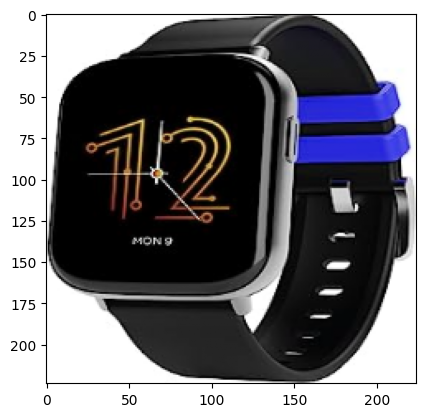

Watch


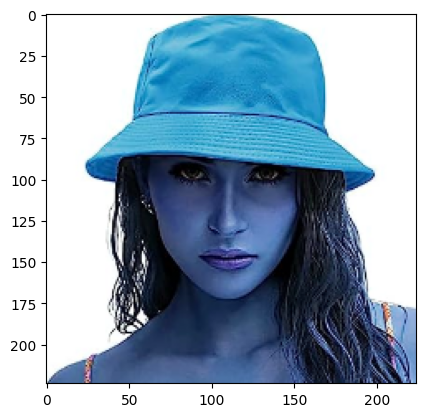

Hat


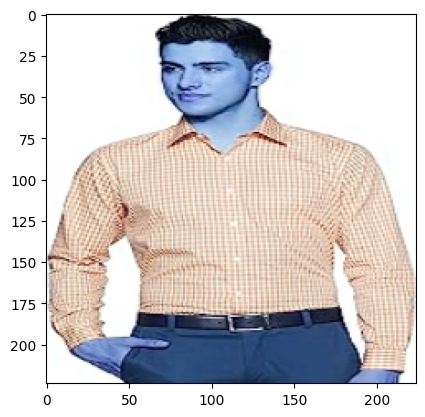

Shirt


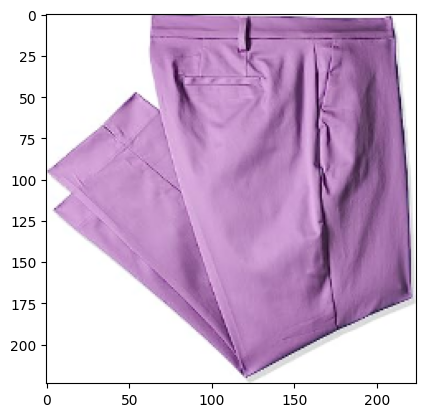

Trousers


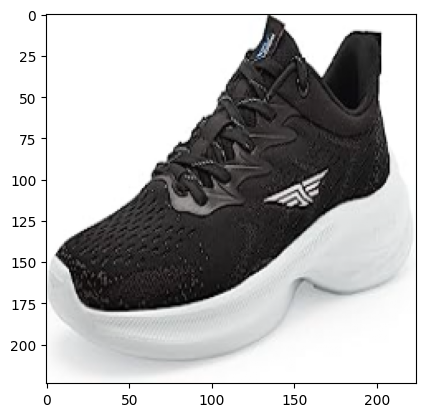

Shoe


In [30]:
get_image_and_class(5)

# **Product Recommendation** <a class="anchor" id="2"></a>

## **1. Text Based Recommendation** <a class="anchor" id="2.1"></a>

### **A. Recommendation based on product title** <a class="anchor" id="2.1.1"></a>

In [31]:
count_vectorize = CountVectorizer(stop_words = 'english')
title_vectorized = count_vectorize.fit_transform(data['Product_name'])
title_vectorized.shape

(1777, 1767)

In [32]:
# Representation of count vectorizer
counts = pd.DataFrame(title_vectorized.toarray(),columns=count_vectorize.get_feature_names_out())
counts

,003_blue_free,01,01_camouflage,01_white_free,02,03,04,05,06,07,...,z126,z146,z2,z3,z4,z6,zebronics,zero,zoom,ztaur
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
cosine_sim_user2 = cosine_similarity(title_vectorized, title_vectorized)

cosine_sim_users2_df=pd.DataFrame(cosine_sim_user2)
cosine_sim_users2_df.columns=data['Product_name']
cosine_sim_users2_df.index=data['Product_name']
cosine_sim_users2_df

Product_name,"Replay Full Sleeves White Shirt with Regular Collar Casual/Formal Shirt | 100% Cotton Fabric, Full Sleeve, Regular Collar Shirt for Men, Regular Fit","Wave Full Sleeves White Formal Shirt with Regular Collar | Cotton Stretch Fabric, Full Sleeve, Regular Collar Shirt for Men, Slim Fit",Men's Cotton Full Sleeve Slim Fit Casual Solid Shirt,White Solid Cotton Full Sleeves Casual Shirt for Men II Stylish Shirt for Men II Exclusive Latest Men Casual Shirt II Luxury Shirts || Branded White Shirt for Men ||,Men's Solid Slim Fit Cotton Casual Shirt with Spread Collar & Full Sleeves,Men's Regular Casual Shirt,Men's Regular Fit Formal Shirt,Slim Fit Cotton Blend Formal Shirts for Men,Men Casual Shirts,Men Casual Shirt,...,Digital Baby Boy's Watch (Black Dial Black Colored Strap),Analog Rose Gold Dial Women's Watch-NM6147NM01 / NL6147NL01/NP6147NM01,"Smart Watch for men women boys 1.3 OLED HD Display, Multiple watch Faces, SpO2 Monitoring, Sleep Monitor for Boys, Girls, Mens, Women & Kids for all Smartphones (ID 116 Plus Black) (ID116 Black)",Edifice Stopwatch Men's Chronograph EFR-539BK-1AVUDF (EX187),Grant Chronograph Black Dial Men's Watch-FS4832,Analog Men's Watch (Brown Dial Brown Colored Strap),Analogue Silver Dial Men's & Boy's Watch RWS0276S,Analog Men's Watch (Brown Dial Brown Colored Strap),Analog Men's Watch (Gold Dial Colored Strap),Grant Chronograph Black Dial Men's Watch-FS4832
Product_name,,,,,,,,,,,,,,,,,,,,,
"Replay Full Sleeves White Shirt with Regular Collar Casual/Formal Shirt | 100% Cotton Fabric, Full Sleeve, Regular Collar Shirt for Men, Regular Fit",1.000000,0.871145,0.492366,0.502865,0.550482,0.696311,0.700649,0.263181,0.201008,0.502519,...,0.000000,0.000000,0.029424,0.061546,0.065795,0.055048,0.065795,0.055048,0.065795,0.065795
"Wave Full Sleeves White Formal Shirt with Regular Collar | Cotton Stretch Fabric, Full Sleeve, Regular Collar Shirt for Men, Slim Fit",0.871145,1.000000,0.516047,0.438069,0.593442,0.521286,0.652753,0.394055,0.120386,0.361158,...,0.000000,0.000000,0.035245,0.073721,0.078811,0.065938,0.078811,0.065938,0.078811,0.078811
Men's Cotton Full Sleeve Slim Fit Casual Solid Shirt,0.492366,0.516047,1.000000,0.557086,0.782624,0.530330,0.474342,0.534522,0.408248,0.612372,...,0.000000,0.000000,0.059761,0.125000,0.133631,0.111803,0.133631,0.111803,0.133631,0.133631
White Solid Cotton Full Sleeves Casual Shirt for Men II Stylish Shirt for Men II Exclusive Latest Men Casual Shirt II Luxury Shirts || Branded White Shirt for Men ||,0.502865,0.438069,0.557086,1.000000,0.539796,0.656532,0.469776,0.297775,0.530669,0.758098,...,0.000000,0.000000,0.088779,0.185695,0.198517,0.166091,0.198517,0.166091,0.198517,0.198517
Men's Solid Slim Fit Cotton Casual Shirt with Spread Collar & Full Sleeves,0.550482,0.593442,0.782624,0.539796,1.000000,0.474342,0.424264,0.478091,0.365148,0.547723,...,0.000000,0.000000,0.053452,0.111803,0.119523,0.100000,0.119523,0.100000,0.119523,0.119523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Analog Men's Watch (Brown Dial Brown Colored Strap),0.055048,0.065938,0.111803,0.166091,0.100000,0.158114,0.141421,0.119523,0.182574,0.182574,...,0.381385,0.316228,0.160357,0.111803,0.358569,1.000000,0.358569,1.000000,0.717137,0.358569
Analogue Silver Dial Men's & Boy's Watch RWS0276S,0.065795,0.078811,0.133631,0.198517,0.119523,0.188982,0.169031,0.142857,0.218218,0.218218,...,0.341882,0.251976,0.191663,0.133631,0.428571,0.358569,1.000000,0.358569,0.428571,0.428571
Analog Men's Watch (Brown Dial Brown Colored Strap),0.055048,0.065938,0.111803,0.166091,0.100000,0.158114,0.141421,0.119523,0.182574,0.182574,...,0.381385,0.316228,0.160357,0.111803,0.358569,1.000000,0.358569,1.000000,0.717137,0.358569


In [34]:
# Accepts PID, Number of most similar products to recommend
def text_recommend_1(pid, num_recommend):
    cosine_sim = cosine_similarity(title_vectorized, title_vectorized)

    recommended_prod = []
    score=[]

    # Displaying query product - PID, Name, Brand
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")
    print("Product ID : " , pid)
    print("Title : ", data['Product_name'][data['PID']==pid].item())
    print("Brand : ", data['Product_Brand'][data['PID']==pid].item())
    print("Price : ",data['Product_Price'][data['PID']==pid].item())
    print("Reviews : ",data['Product_Reviews'][data['PID']==pid].item())
    print("Rating : ",data['Product_Rating'][data['PID']==pid].item())

    # Getting indexes, scores of N most similar products
    score_series = pd.Series(cosine_sim[pid]).sort_values(ascending = False)
    top_10_indexes = list(score_series.iloc[1:(num_recommend+1)].index)
    top_10_score=list(score_series.iloc[1:(num_recommend+1)])

    # Displaying recommended products - Image, PID, Name, Brand, Similarity Score
    print("\n")
    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------")

    for i in range(0,len(top_10_score)):
        recommended_prod.append(list(data['Product_name'])[i])
        print("\nProduct ID : " , top_10_indexes[i])
        print("Title : ", data['Product_name'][data['PID']==top_10_indexes[i]].item())
        print("Brand : ", data['Product_Brand'][data['PID']==top_10_indexes[i]].item())
        print("Price : ",data['Product_Price'][data['PID']==top_10_indexes[i]].item())
        print("Reviews : ",data['Product_Reviews'][data['PID']==top_10_indexes[i]].item())
        print("Rating : ",data['Product_Rating'][data['PID']==top_10_indexes[i]].item())
        print("Similarity score : ",top_10_score[i])


In [35]:
text_recommend_1(1000,5)

-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------
Product ID :  1000
Title :  Men Black Walking Shoes
Brand :  Red Tape
Price :  1724.0
Reviews :  2.0
Rating :  4.5


-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------

Product ID :  732
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1699.0
Reviews :  532.0
Rating :  4.0
Similarity score :  0.8660254037844388

Product ID :  1026
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1391.0
Reviews :  36.0
Rating :  3.9
Similarity score :  0.8660254037844388

Product ID :  936
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1322.0
Reviews :  681.0
Rating :  3.9
Similarity score :  0.8660254037844388

Product ID :  895
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1299.0
Reviews :  91.0


### **B. Recommendation based on product title and brand** <a class="anchor" id="2.1.1"></a>

In [36]:
brand_vectors = CountVectorizer(stop_words = 'english')
brand_vectorized = brand_vectors.fit_transform(data['Product_Brand'])

In [37]:
# Accepts PID, Number of most similar products to recommend, weights for the word-2-vec features: product name and brand
def text_recommend_2(pid, num_recommend, w1, w2):
    title_sim  = cosine_similarity(title_vectorized, title_vectorized)
    brand_sim = cosine_similarity(brand_vectorized, brand_vectorized)
    total_sim   = (w1 * title_sim +  w2 * brand_sim)/float(w1 + w2)

    recommended_prod = []
    score=[]

    # Displaying query product - PID, Name, Brand
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")
    print("Product ID : " , pid)
    print("Title : ", data['Product_name'][data['PID']==pid].item())
    print("Brand : ", data['Product_Brand'][data['PID']==pid].item())
    print("Price : ",data['Product_Price'][data['PID']==pid].item())
    print("Reviews : ",data['Product_Reviews'][data['PID']==pid].item())
    print("Rating : ",data['Product_Rating'][data['PID']==pid].item())

    # Getting indexes, scores of N most similar products
    score_series = pd.Series(total_sim[pid]).sort_values(ascending = False)
    top_indexes = list(score_series.iloc[1:(num_recommend+1)].index)
    top_score=list(score_series.iloc[1:(num_recommend+1)])

    # Displaying recommended products - Image, PID, Name, Brand, Similarity Score
    print("\n")
    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------")

    for i in range(0,len(top_score)):
        recommended_prod.append(list(data['Product_name'])[i])
        print("\nProduct ID : " , top_indexes[i])
        print("Title : ", data['Product_name'][data['PID']==top_indexes[i]].item())
        print("Brand : ", data['Product_Brand'][data['PID']==top_indexes[i]].item())
        print("Price : ",data['Product_Price'][data['PID']==top_indexes[i]].item())
        print("Reviews : ",data['Product_Reviews'][data['PID']==top_indexes[i]].item())
        print("Rating : ",data['Product_Rating'][data['PID']==top_indexes[i]].item())
        print("Similarity score : ",top_score[i])



In [38]:
text_recommend_2(1000,5,0.75,0.25)

-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------
Product ID :  1000
Title :  Men Black Walking Shoes
Brand :  Red Tape
Price :  1724.0
Reviews :  2.0
Rating :  4.5


-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------

Product ID :  1026
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1391.0
Reviews :  36.0
Rating :  3.9
Similarity score :  0.899519052838329

Product ID :  895
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1299.0
Reviews :  91.0
Rating :  3.9
Similarity score :  0.899519052838329

Product ID :  936
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1322.0
Reviews :  681.0
Rating :  3.9
Similarity score :  0.899519052838329

Product ID :  732
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1699.0
Reviews :  532.0
Rat

## **2. Image Based Recommendation** <a class="anchor" id="2.2"></a>

In [39]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

553467096/553467096 [==============================] - 21s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [48]:
! mkdir images

In [49]:
!python3 product.py --recommend 1 --pages 3

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 444, in _error_catcher
    yield
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 828, in read_chunked
    self._update_chunk_length()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 758, in _update_chunk_length
    line = self._fp.fp.readline()
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1274, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.10/ssl.py", line 1130, in read
    return self._sslobj.read(len, buffer)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/product.py", line 103, in <module>
    search_results.run(url, args.pages)
  File "/content/search_results.py", line 46, in run
    data = scrape(url) 
  File

In [52]:
imgs_path = "images/"

# Downloading all images from urls
for idx, row in data.iterrows():
    url = row['Product_Image']
    if(url!='nan' and url):
        try:
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            img.save(imgs_path + str(row['PID']) + '.jpeg')
        except:
            pass


imgs_model_width, imgs_model_height = 224,224

files = [imgs_path + x for x in os.listdir(imgs_path) if "jpeg" in x]

print("Number of images:",len(files))

Number of images: 1127


In [53]:
# Extracting PID from file names
_re_digits = re.compile(r'\d+')
pid = []
for element in files:
    pid += [int(n) for n in _re_digits.findall(element)]

# Adding pid and image url to a dataframe
df={'PID':pid,'Images':files}
df=pd.DataFrame(df)

# Preprocessing images for feeding into CNN (VGG16)
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [54]:
# Extracting image features
imgs_features = feat_extractor.predict(processed_imgs)
print("Features successfully extracted.")
imgs_features.shape

36/36 [==============================] - 661s 18s/step
Features successfully extracted.


(1127, 4096)

In [55]:
# Computing and storing cosine similarities between images
cosSimilarities = cosine_similarity(imgs_features)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df

,images/937.jpeg,images/61.jpeg,images/522.jpeg,images/1570.jpeg,images/451.jpeg,images/843.jpeg,images/673.jpeg,images/262.jpeg,images/1164.jpeg,images/17.jpeg,...,images/584.jpeg,images/750.jpeg,images/1394.jpeg,images/1008.jpeg,images/858.jpeg,images/731.jpeg,images/537.jpeg,images/1217.jpeg,images/186.jpeg,images/1405.jpeg
images/937.jpeg,1.000000,0.299375,0.282092,0.324048,0.333031,0.620223,0.256090,0.262806,0.328622,0.347920,...,0.274470,0.578532,0.355589,0.658843,0.733457,0.732685,0.434136,0.373985,0.344837,0.227885
images/61.jpeg,0.299375,1.000000,0.498730,0.103412,0.525895,0.225173,0.435176,0.620973,0.284327,0.592626,...,0.482201,0.256659,0.189194,0.218391,0.209401,0.226203,0.409753,0.287272,0.356464,0.171213
images/522.jpeg,0.282092,0.498730,1.000000,0.106279,0.696242,0.253145,0.621475,0.462255,0.290057,0.489917,...,0.703466,0.384409,0.195240,0.289203,0.242473,0.260746,0.528978,0.330103,0.300633,0.203292
images/1570.jpeg,0.324048,0.103412,0.106279,1.000000,0.123850,0.311475,0.122489,0.128612,0.128640,0.141092,...,0.104830,0.289669,0.182090,0.368682,0.358182,0.335336,0.192779,0.181723,0.156763,0.123969
images/451.jpeg,0.333031,0.525895,0.696242,0.123850,1.000000,0.244897,0.759755,0.572125,0.280834,0.522565,...,0.832250,0.324734,0.166545,0.277967,0.287576,0.275183,0.549752,0.226028,0.354554,0.164819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
images/731.jpeg,0.732685,0.226203,0.260746,0.335336,0.275183,0.599328,0.243246,0.243918,0.289915,0.312958,...,0.244428,0.632586,0.382394,0.696017,0.740057,1.000000,0.350475,0.395764,0.302076,0.241353
images/537.jpeg,0.434136,0.409753,0.528978,0.192779,0.549752,0.270329,0.512503,0.418429,0.280116,0.470201,...,0.607969,0.341271,0.214219,0.363522,0.355627,0.350475,1.000000,0.344342,0.269812,0.170533
images/1217.jpeg,0.373985,0.287272,0.330103,0.181723,0.226028,0.301520,0.223371,0.223884,0.272553,0.347278,...,0.229132,0.365902,0.287274,0.379866,0.292544,0.395764,0.344342,1.000000,0.211151,0.416304
images/186.jpeg,0.344837,0.356464,0.300633,0.156763,0.354554,0.274900,0.307147,0.471826,0.337659,0.495995,...,0.320230,0.309340,0.161600,0.280792,0.319518,0.302076,0.269812,0.211151,1.000000,0.218362


In [56]:
# Accepts PID, Number of most similar products to recommend
def image_recommend_1(pid, num_recommend = 5):
    given_img=df['Images'][df['PID']==pid].item()

    # Displaying query product- Image, PID, Name, Brand
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")

    print("\nProduct ID : ",pid)
    print("Title : ",data['Product_name'][data['PID']==pid].item())
    print("Brand : ",data['Product_Brand'][data['PID']==pid].item())
    print("Price : ",data['Product_Price'][data['PID']==pid].item())
    print("Reviews : ",data['Product_Reviews'][data['PID']==pid].item())
    print("Rating : ",data['Product_Rating'][data['PID']==pid].item())
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    # Getting indexes, scores of N most similar products
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:num_recommend+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:num_recommend+1]

    # Extracting PIDs from image files
    _re_digits = re.compile(r'\d+')
    closest_imgs_pid = []
    for element in closest_imgs:
        closest_imgs_pid += [int(n) for n in _re_digits.findall(element)]

    # Displaying recommended products - Image, PID, Name, Brand, Similarity Score
    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------")

    for i in range(0,len(closest_imgs)):
        print("\nProduct ID : ",closest_imgs_pid[i])
        print("Title : ",data['Product_name'][data['PID']==closest_imgs_pid[i]].item())
        print("Brand : ",data['Product_Brand'][data['PID']==closest_imgs_pid[i]].item())
        print("Price : ",data['Product_Price'][data['PID']==closest_imgs_pid[i]].item())
        print("Reviews : ",data['Product_Reviews'][data['PID']==closest_imgs_pid[i]].item())
        print("Rating : ",data['Product_Rating'][data['PID']==closest_imgs_pid[i]].item())
        print("similarity score : ",closest_imgs_scores[i])

        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()

-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------

Product ID :  1000
Title :  Men Black Walking Shoes
Brand :  Red Tape
Price :  1724.0
Reviews :  2.0
Rating :  4.5


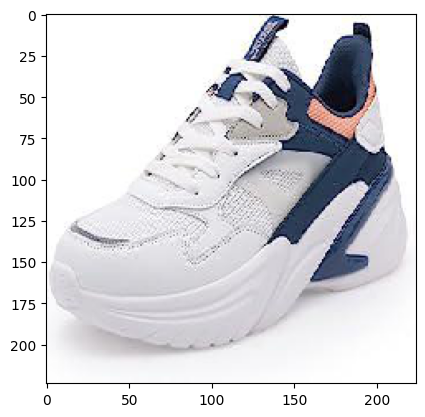

-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------

Product ID :  1019
Title :  Men Olive Walking Shoes
Brand :  Red Tape
Price :  1724.0
Reviews :  30.0
Rating :  3.9
similarity score :  0.90065014


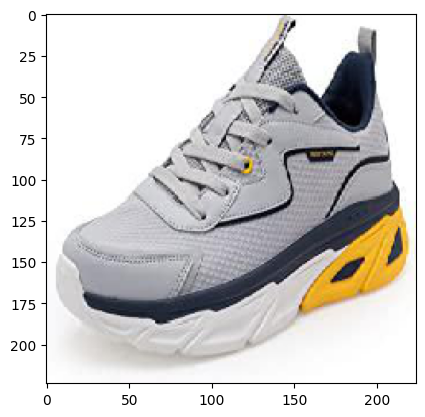


Product ID :  757
Title :  Men's Running Shoes
Brand :  ASIAN
Price :  524.0
Reviews :  6754.0
Rating :  3.8
similarity score :  0.88353527


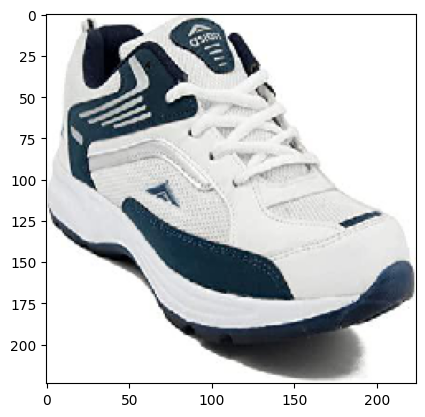


Product ID :  942
Title :  Men's FUTURE-01 Sports Running,Walking & Gym Shoes with Eva Sole Extra Jump Casual Sneaker Shoes for Men's & Boy's
Brand :  ASIAN
Price :  524.0
Reviews :  6754.0
Rating :  3.8
similarity score :  0.88353515


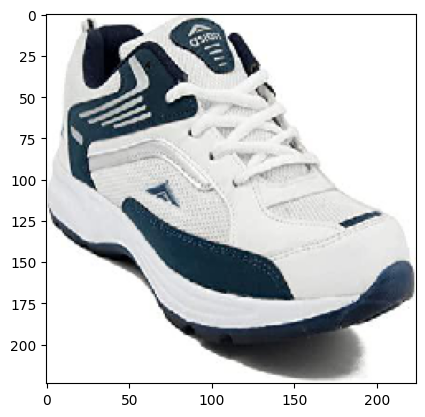


Product ID :  977
Title :  Men's FUTURE-01 Sports Running,Walking & Gym Shoes with Eva Sole Extra Jump Casual Sneaker Shoes for Men's & Boy's
Brand :  ASIAN
Price :  524.0
Reviews :  6754.0
Rating :  3.8
similarity score :  0.8807243


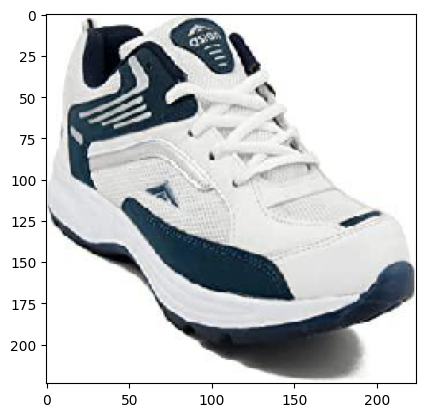


Product ID :  732
Title :  Men's Walking Shoes
Brand :  Red Tape
Price :  1699.0
Reviews :  532.0
Rating :  4.0
similarity score :  0.8554539


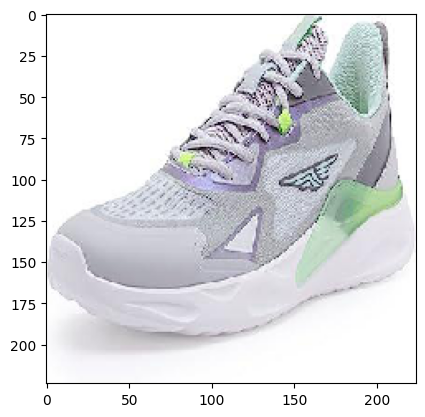

In [57]:
image_recommend_1(1000,5)